In [1]:
import geoengine as ge
from geoengine.workflow_builder.operators import GdalSource, TemporalRasterAggregation, RasterStacker, RenameBands, \
    Expression,RasterTypeConversion, RasterBandDescriptor
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
ge.initialize("https://zentrale.app.geoengine.io/api", token="51c46772-6c55-4867-8e42-c9fd8b614820")

In [3]:
weimar_center_utm = [479763, 5623423]
bbox = ge.BoundingBox2D(
    xmin=weimar_center_utm[0] - 10 * 512,
    xmax=weimar_center_utm[0] + 10 * 512,
    ymin=weimar_center_utm[1] - 10 * 512,
    ymax=weimar_center_utm[1] + 10 * 512,
)
query_rectangle=ge.QueryRectangle(
    spatial_bounds=bbox,
    time_interval=ge.TimeInterval(np.datetime64("2022-07-01T00:00:00")),
    srs='EPSG:32632',
    resolution=ge.SpatialResolution(10, 10),
)

In [4]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [5]:
rgb = TemporalRasterAggregation(
  aggregation_type='mean',
  granularity='days',
  window_size=5,
  ignore_no_data=True,
  source=RasterStacker(
    sources=[
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`"),
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`"),
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`"),
    ],
    rename=RenameBands.rename(['red', 'green', 'blue']),
  )
)

# print(json.dumps(rgb, indent=2))

rgb = ge.register_workflow(rgb)

rgb

1c1f63bb-ec2a-56a9-bacc-3eff598ee7fe

In [6]:
rgb_array = await rgb.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2], # TODO: improve for user, default = all? where are the band names?
)

rgb_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 3, y: 1025, x: 1025)>
array([[[[1240., 1228., 1256., ...,  599.,  822.,  692.],
         [1128., 1118., 1132., ...,  533.,  584.,  650.],
         [1005.,  946.,  922., ...,  476.,  353.,  594.],
         ...,
         [1236., 1048., 1058., ...,  797.,  951.,  984.],
         [ 938.,  912.,  828., ...,  827., 1040.,  930.],
         [ 912.,  808.,  727., ...,  812.,  984.,  805.]],

        [[1520., 1512., 1512., ...,  712.,  902.,  762.],
         [1336., 1368., 1368., ...,  505.,  618.,  752.],
         [1194., 1168., 1146., ...,  550.,  540.,  696.],
         ...,
         [1014., 1038., 1018., ...,  754.,  830.,  809.],
         [1020.,  987.,  874., ...,  804.,  850.,  795.],
         [ 980.,  849.,  850., ...,  791.,  830.,  728.]],

        [[ 965.,  955.,  960., ...,  466.,  711.,  542.],
         [ 902.,  881.,  888., ...,  297.,  456.,  506.],
         [ 860.,  850.,  799., ...,  357.,  335.,  614.],
         ...,
         [ 704.,  723.,  814., ...,  538.,  675.,  592.],
         [ 687.,  786.,  666., ...,  506.,  593.,  534.],
         [ 708.,  774.,  564., ...,  506.,  558.,  472.]]]])
Coordinates:
  * x            (x) float64 4.746e+05 4.747e+05 ... 4.849e+05 4.849e+05
  * y            (y) float64 5.629e+06 5.629e+06 ... 5.618e+06 5.618e+06
  * time         (time) datetime64[ns] 2022-06-27
  * band         (band) int64 0 1 2
    spatial_ref  int64 0

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


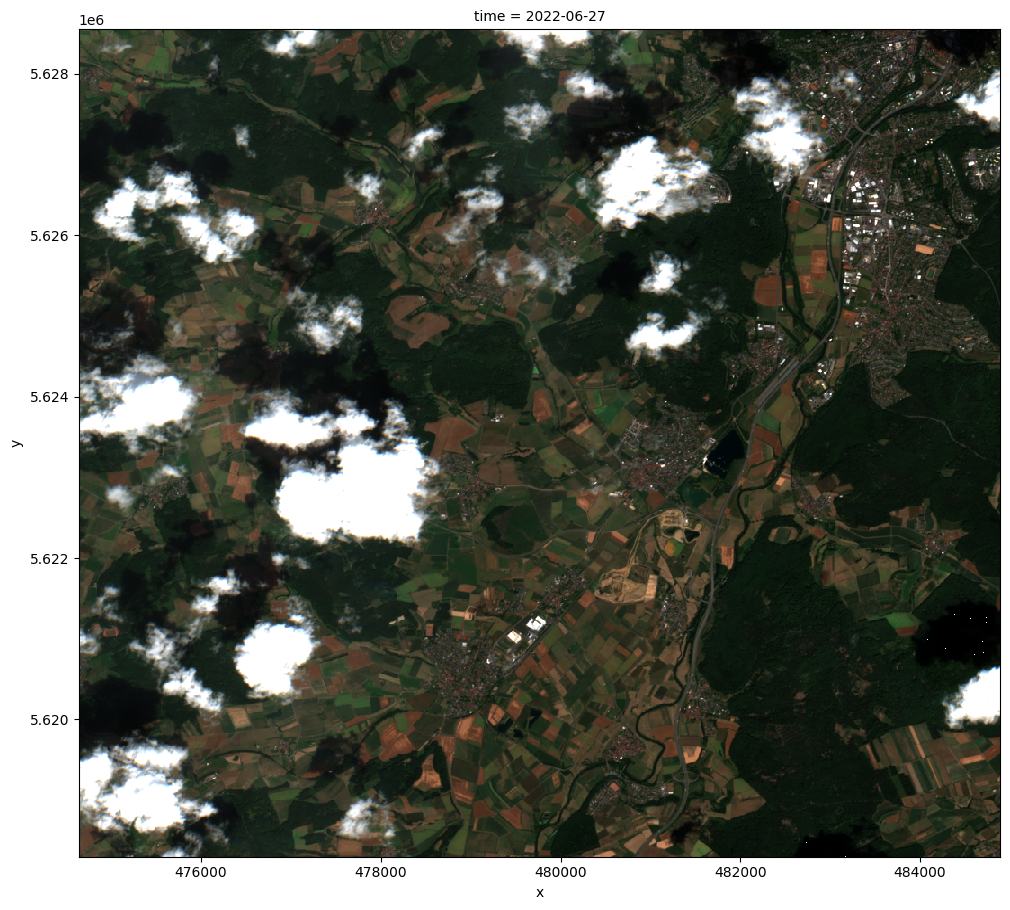

In [7]:
rgb_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
);

In [8]:
def cloud_free(band: GdalSource):
    return Expression(
        # expression = 'if B < 8 { A } else { NODATA }',
        expression = 'if B > 2 && B < 8 { A } else { NODATA }',
        source=RasterStacker(
          sources=[
              band,
              RasterTypeConversion(
                  GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
                  output_data_type='U16',
              ),
          ],
        )
    )

rgb_cloud_free = TemporalRasterAggregation(
  aggregation_type='mean', # 'percentileEstimate',
  # percentile=0.5,
  granularity='months',
  window_size=1,
  ignore_no_data=True,
  source=RasterStacker(
    sources=[
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`")),
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")),
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`")),
    ],
    rename=RenameBands.rename(['red', 'green', 'blue']),
  )
)

# print(json.dumps(rgb, indent=2))

rgb_cloud_free = ge.register_workflow(rgb_cloud_free)

rgb_cloud_free

f8ecb124-0925-5c27-b58a-7c6803467463

In [9]:
rgb_cloud_free_array = await rgb_cloud_free.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2], # TODO: improve for user, default = all? where are the band names?
)

rgb_cloud_free_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 3, y: 1025, x: 1025)>
array([[[[2711.3333 , 2706.6667 , 2695.3333 , ...,  695.     ,
           956.     ,  824.     ],
         [2264.     , 2326.6667 , 2404.     , ...,  671.5    ,
           749.     ,  718.     ],
         [2049.3333 , 2038.     , 2060.     , ...,  712.     ,
           471.5    ,  705.5    ],
         ...,
         [1524.     , 1274.     ,  979.3333 , ...,  908.5    ,
          1113.     , 1184.     ],
         [1084.6666 ,  868.6667 ,  615.3333 , ..., 1037.     ,
          1229.     , 1198.     ],
         [ 936.3333 ,  650.3333 ,  565.3333 , ..., 1140.     ,
          1226.     , 1052.     ]],

        [[1929.3334 , 1959.3334 , 1963.3334 , ...,  809.     ,
          1014.5    ,  849.     ],
         [1584.     , 1660.     , 1719.3334 , ...,  727.     ,
           767.5    ,  829.     ],
         [1442.     , 1437.3334 , 1454.     , ...,  746.     ,
           642.5    ,  735.     ],
...
         [1220.6666 , 1087.3334 ,  881.3333 , ...,  798.5    ,
           915.     ,  969.     ],
         [ 973.     ,  840.3333 ,  629.6667 , ...,  915.     ,
           980.5    ,  964.     ],
         [ 829.     ,  673.6667 ,  610.     , ...,  961.     ,
           961.     ,  852.5    ]],

        [[1445.     , 1472.     , 1472.     , ...,  547.     ,
           844.5    ,  645.     ],
         [1162.     , 1209.3334 , 1257.6666 , ...,  518.     ,
           589.5    ,  606.     ],
         [1072.6666 , 1070.6666 , 1078.6666 , ...,  595.5    ,
           416.5    ,  577.     ],
         ...,
         [1061.     ,  853.     ,  741.3333 , ...,  618.     ,
           757.     ,  714.     ],
         [ 819.     ,  663.3333 ,  533.3333 , ...,  715.     ,
           721.     ,  720.     ],
         [ 759.6667 ,  624.     ,  474.66666, ...,  714.     ,
           704.     ,  630.5    ]]]], dtype=float32)
Coordinates:
  * x            (x) float64 4.746e+05 4.747e+05 ... 4.849e+05 4.849e+05
  * y            (y) float64 5.629e+06 5.629e+06 ... 5.618e+06 5.618e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0 1 2
    spatial_ref  int64 0

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


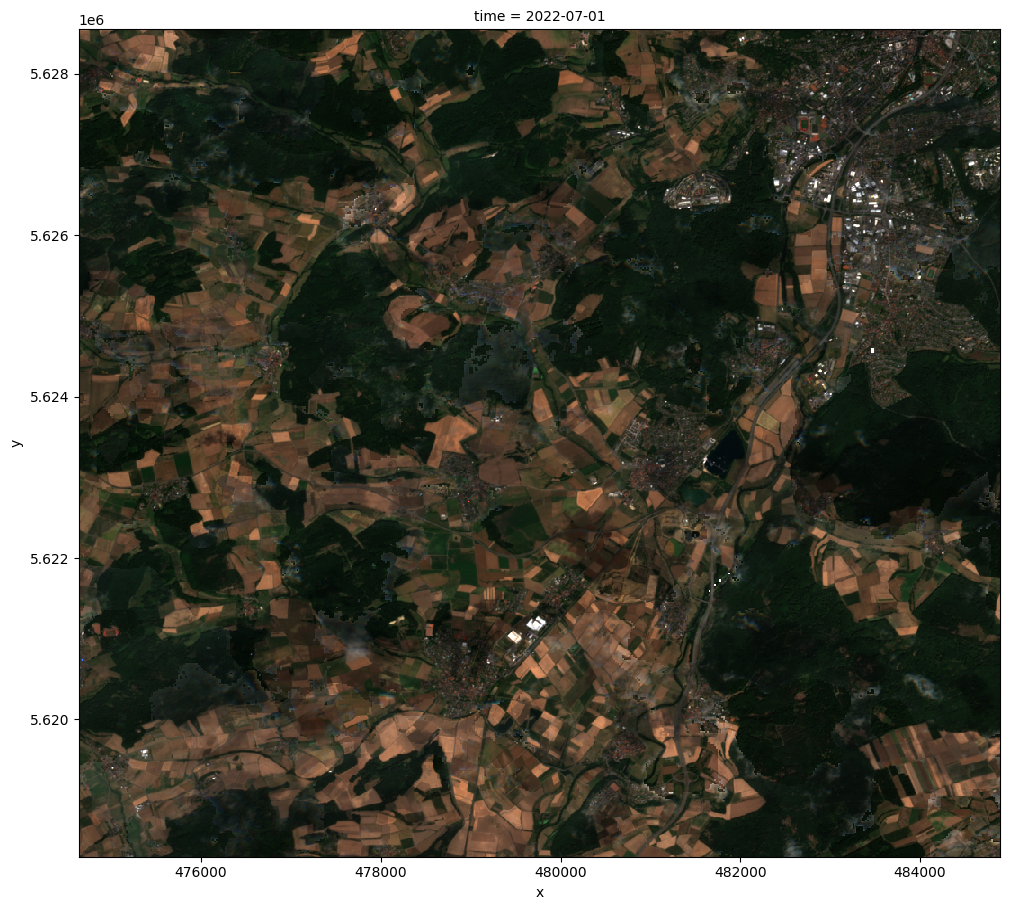

In [10]:
rgb_cloud_free_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
);

In [14]:
'''
water_bodies = Expression(
    expression='if (A-B)/(A+B) > 0.3 { 1 } else { 0 }',
    output_type='U8',
    output_band=RasterBandDescriptor(
        "water bodies",
        measurement=ge.ClassificationMeasurement(
            "water bodies",
            classes={
                0: 'no water',
                1: 'water',
            }
        ),
    ),
    source=TemporalRasterAggregation(
        aggregation_type='mean',
        granularity='months',
        window_size=1,
        ignore_no_data=True,
        source=RasterStacker(
            sources=[
                cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")),
                cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`")),
            ],
        ),
    ),
)
'''

water_bodies = TemporalRasterAggregation(
    aggregation_type='max',
    granularity='months',
    window_size=1, # 9,
    ignore_no_data=True,
    source=Expression(
        expression='''
            if C >= 8 {
                NODATA
            } else if (A-B)/(A+B) > 0.05 {
                1
            } else {
                0
            }
        ''',
        output_type='U8',
        # output_band=RasterBandDescriptor( # TODO: this is broken in the backend
        #     "water bodies",
        #     measurement=ge.ClassificationMeasurement(
        #         "water bodies",
        #         classes={
        #             0: 'no water',
        #             1: 'water',
        #         }
        #     ),
        # ),
        source=
            RasterStacker(
                sources=[
                    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`"),
                    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`"),
                    RasterTypeConversion(
                        GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
                        output_data_type='U16',
                    ),
                ],
            ),
    ),
)

# print(json.dumps(water_bodies.to_workflow_dict(), indent=2))

water_bodies = ge.register_workflow(water_bodies)

water_bodies

7b06c125-d7c9-53e0-831d-ef238b3285f3

In [15]:
water_bodies_array = await water_bodies.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0], # TODO: improve for user, default = all? where are the band names?
)

water_bodies_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


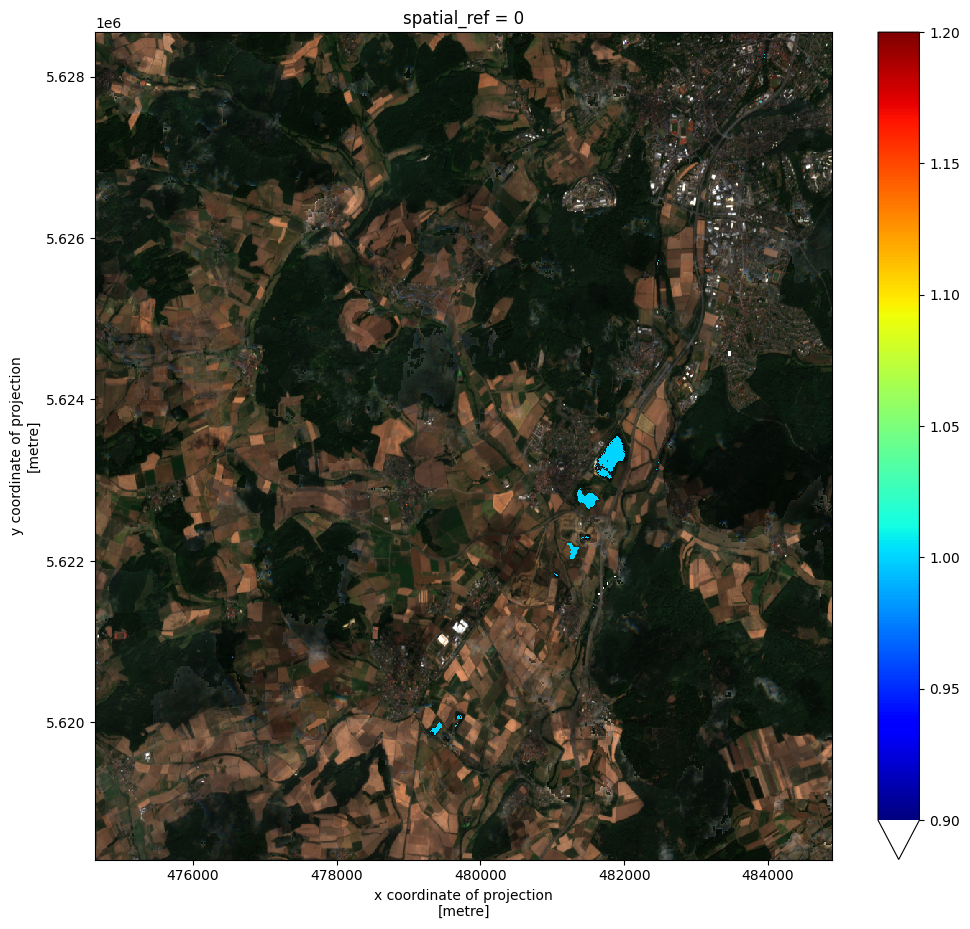

In [ ]:
fg = rgb_cloud_free_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
)

cmap = plt.cm.jet
cmap.set_under('white',0.)

for ax in fg.axs:
    water_bodies_array.isel(band=0, time=0, drop=True).plot.imshow(
        cmap=cmap,
        vmin=0.9,
        vmax=1.2,
        ax=ax[0],
    )


In [83]:
fg.axs[0][0]

<Axes: title={'center': 'time = 2022-07-01'}, xlabel='x', ylabel='y'>